# The hands-on workflow

The full development workflow we will follow is:

![workflow](images/workflow.png)

In this notebook:
 - We will use **sinabs** to define and train our network
 - The network will be run using the sinabs "simulator" to obtain **sparsity** and **accuracy** metrics
 - The network will be deployed to **speck**, to obtain the **inference speed** as well. **NOTE:** For this step you need the hardware chip and you need to run the notebooks locally instead of on colab. If you want to try this out you can ask to the presenters for more information.
 - We will then do some basic analysis of how sparsity affects accuracy and speed.
 - Finally, we export the model to **NIR**.

This notebook has been adapted from https://sinabs.readthedocs.io/v3.0.3/tutorials/nmnist.html

See also https://www.youtube.com/watch?v=kOiyRtvPO2Q for more in-depth details of sinabs.  

# Package installation 

Execute only if you are usng Goolge Colab. If you are using your own local environment make sure you installed the dependecies first


In [124]:
!pip install tonic
!pip install sinabs
!pip install torchmetrics
!pip install neurobench
!pip install snntorch
!pip install pandas
!pip install numpy --upgrade # make sure you have the last version of numpy, this could require to restart the session on Google Colab


  Using cached numpy-1.26.4-cp313-cp313-linux_x86_64.whl
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.2
    Uninstalling numpy-2.3.2:
      Successfully uninstalled numpy-2.3.2
  Using cached numpy-2.3.2-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
Using cached numpy-2.3.2-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.61.2 requires numpy<2.3,>=1.24, but you have numpy 2.3.2 which is incompatible.
tonic 1.6.0 requires numpy<2.0.0, but you have numpy 2.3.2 which is incompatible.


# Import packages

In [125]:
import numpy as np
import torch
import torch.nn as nn
import torchmetrics
import os
import sinabs
import sinabs.layers as sl
from tqdm import tqdm

from sinabs.hooks import register_synops_hooks

# Device setting

Set the availble device to train the model

In [126]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")
    print("Using CPU")

Using CPU


# Dataset Definition

We will use a simple dataset, the **neuromorphic N-MNIST** for demonstration purposes.

From https://www.garrickorchard.com/datasets/n-mnist:

> The Neuromorphic-MNIST (N-MNIST) dataset is a spiking version of the original frame-based MNIST dataset. It consists of the same 60 000 training and 10 000 testing samples as the original MNIST dataset, and is captured at the same visual scale as the original MNIST dataset (28x28 pixels). The N-MNIST dataset was captured by mounting the ATIS sensor on a motorized pan-tilt unit and having the sensor move while it views MNIST examples on an LCD monitor

We will get the data using the **tonic** library, which automatically handles the download ands extraction in case it does not exists.

From https://tonic.readthedocs.io/en/latest/index.html:

> Tonic provides publicly available event-based vision and audio datasets and event transformations. The package is fully compatible with PyTorch Vision / Audio to give you the flexibility that you need.

In [127]:
from tonic import datasets, transforms

def get_data_loaders(batch_size):

    transform = transforms.Compose([
        transforms.ToFrame(sensor_size=(34, 34, 2), n_time_bins=30, include_incomplete=True),  # Go from list of events to sparse frames
        lambda x: torch.from_numpy(x.astype(np.float32)),  # just to go from int to float, for compatibility with pytorch
    ])

    trainset = datasets.NMNIST('./data', train=True, transform=transform)
    testset = datasets.NMNIST('./data', train=False, transform=transform)

    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=0,
        drop_last=True, pin_memory=True
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, num_workers=0,
        drop_last=True, pin_memory=True
    )

    return trainloader, testloader

# Examine data

Lets get one single data point and plot the first frame (which will not show much), and the addition of 10 frames

torch.Size([1, 30, 2, 34, 34])


/home/walter/miniforge3/envs/speck/lib/python3.13/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


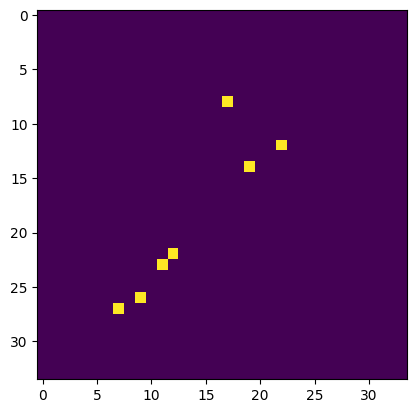

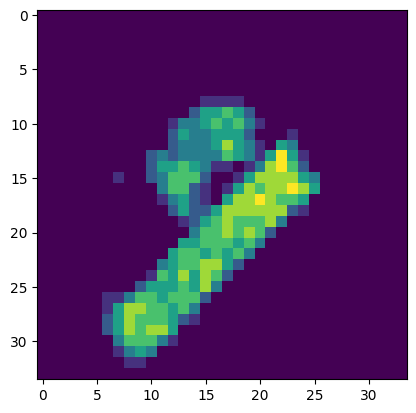

In [128]:
import matplotlib.pyplot as plt
tl, _ = get_data_loaders(1)
data, _ = next(iter(tl))
print(data.shape)
data = data[0] # remove batch dimension
plt.imshow(data[0, 0])  # one single frame, that can be used for SNN (as it has state)
plt.figure()
plt.imshow(data[:10, 0].sum(0)) # fist 10 frames added, for instance for a stateless ANN (normal convs)

# Model definition

Define a SNN model made of convolutional layers and **LIF** neurons.
As the task is relatively simple, and we want to keep training times reasonable for demonstration purposes, the model is simple as well.

Some considerations (this is very specific to Speck and probably not worth spending too much time on it):
 - **biases** are set to False to avoid running at fixed frequency on the chip: https://sinabs.readthedocs.io/v3.0.3/speck/notebooks/leak_neuron.html
 - The dimensions of our data are 5: **[batch, time, channels, height, width]**. Due to how speck works, the time needs to be flattened. This is because all the time steps are feed all at once instead of one by one. This means the first two dimensions (batch_size and time) are flattened together. In other words, the time dimension is treated as part of the batch size. This is done with the **FlattenTime()** class. The conv layers do not care about time, but the **IAF** layers do. That is why we use the **IAFSqueeze** version, that internally **unflattens** the time dimension and runs it one by one.

In [129]:
def create_model(batch_size):

    backend = sl
    min_v_mem = -1.  # cap the mem potential. Helpful when running on chip, to avoid quantization issues.

    model = nn.Sequential(
        sl.FlattenTime(),  # required by speck. Make the 5D input 4D, by treating the time as part of the batch size

        nn.Conv2d(2, 8, kernel_size=3, stride=2, padding=1, bias=False),
        backend.IAFSqueeze(batch_size=batch_size, min_v_mem=min_v_mem), # Actual spiking layer.

        nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1, bias=False),
        backend.IAFSqueeze(batch_size=batch_size, min_v_mem=min_v_mem),

        nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False),
        backend.IAFSqueeze(batch_size=batch_size, min_v_mem=min_v_mem),

        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
        backend.IAFSqueeze(batch_size=batch_size, min_v_mem=min_v_mem),

        nn.Conv2d(64, 10, kernel_size=3, stride=1, padding=0, bias=False),
        backend.IAFSqueeze(batch_size=batch_size, min_v_mem=min_v_mem),

        nn.Flatten(),
        sl.UnflattenTime(batch_size=batch_size),
    )
    return model


# Evaluation

The following helper function just evaluates the model on a test set, using **cross entropy** between the prediction and the target 

In [130]:
def evaluate_model(model, testloader, device):

    acc = torchmetrics.Accuracy('multiclass', num_classes=10).to(device)
    model.eval()

    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for data, targets in tqdm(testloader, desc="Evaluating"):
            data, targets = data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            sinabs.reset_states(model)

            y_hat = model(data)
            pred = y_hat.sum(1)
            loss = nn.functional.cross_entropy(pred, targets)

            acc(pred, targets)
            total_loss += loss.item()
            num_batches += 1

    accuracy = acc.compute().item()
    avg_loss = total_loss / num_batches

    return accuracy, avg_loss

# Training Process with target synaptic operations

One of the main drivers of model performance (accuracy and speed), is the activation sparsity.

We control this with the **target_synops** parameter. This parameter is used together with the cross entropy between target and prediction, to calculate a loss that takes into account both accuracy and activity.

In [131]:
def train_and_evaluate(lr, batch_size, epochs, name, target_synops=False, max_iters=10000):

    learning_rate = lr
    batch_size = batch_size
    n_epochs = epochs

    acc = torchmetrics.Accuracy('multiclass', num_classes=10).to(device)

    # Create model and move to device
    model = create_model(batch_size)
    model = model.to(device)

    if target_synops:
        # Register synops hooks
        register_synops_hooks(model)

    # Create data loaders
    trainloader, testloader = get_data_loaders(batch_size)

    # Create optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Track best loss
    best_acc = 0

    for epoch in range(n_epochs):
        model.train()

        pbar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{n_epochs}')

        sinabs.reset_states(model)
        sinabs.zero_grad(model)
        optimizer.zero_grad()

        iters = 0
        for data, targets in pbar:

            sinabs.reset_states(model)
            optimizer.zero_grad()

            data, targets = data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            output = model(data).sum(1)

            target_loss = nn.functional.cross_entropy(output, targets)
            if target_synops:
                synops = model.hook_data['total_synops_per_timestep']
                synops_loss = ((synops - target_synops) / target_synops) ** 2
                loss = 0.8 * target_loss + 0.2 * synops_loss
            else:
                loss = target_loss

            accuracy = acc(output, targets)
            loss.backward()
            optimizer.step()

            current_loss = loss.item()

            # Update progress bar
            pbar.set_postfix({
                'train_loss': f'{current_loss:.4f}',
                'train_acc': f'{accuracy.item():.2%}',
            })
            iters +=1
            if iters > max_iters:
                break

        # Evaluate on test set
        test_acc, test_loss = evaluate_model(model, testloader, device)

        pbar.set_postfix({
            'train_loss': f'{current_loss:.4f}',
            'train_acc': f'{accuracy:.2%}',
            'test_loss': f'{test_loss:.4f}',
            'test_acc': f'{test_acc:.4f}',
        })

        # Save best model
        if test_loss < best_loss:
            best_loss = test_loss
            best_acc = test_acc
            os.makedirs('saved_models', exist_ok=True)
            torch.save(model.cpu(), f'saved_models/{name}.pth')
            print(f"New best model saved with loss {best_loss:.4f} and {best_acc=}")
            model.to(device)

    print("\nTraining complete.")
    print(f"Final accuracy: {best_acc:.2%}")
    print(f"Final loss: {best_loss:.4f}")

    return {"accuracy": best_acc,
            "loss": best_loss}

### Train with no synops regulation

Lets first train without any synops regulation, to get an idea of the number of synaptic operations in the model when it is unconstrained.

**NOTE:** We are using only one epoch just for demo purposes. As the task is simple and the model is oversized for the task, one epoch is enough to get decent accuracy.

In [ ]:
all_results: dict[dict] = {}

lr = 1e-3
batch_size = 32
epochs = 1

all_results['100'] = train_and_evaluate(lr, batch_size, epochs, '100', target_synops=False)


Evaluating: 100%|██████████| 312/312 [00:28<00:00, 10.80it/s]

New best model saved with loss 2.3026 and best_acc=0.09815704822540283

Training complete.
Final accuracy: 9.82%
Final loss: 2.3026


# Model statistics on Simulation

We can use sinabs **hooks** in order to collect data the synaptic operations performed when simulating. We define the following helper functions:

In [142]:
import sinabs.layers as sl

from sinabs.hooks import register_synops_hooks, firing_rate_hook, get_hook_data_dict

def record_output_hook(module, input, output):
    data = get_hook_data_dict(module)
    data["output"] = output

def register_hooks(model):
    register_synops_hooks(model)
    for layer in model:
        if isinstance(layer, sl.StatefulLayer) and layer.does_spike:
            layer.register_forward_hook(firing_rate_hook)
            layer.register_forward_hook(record_output_hook)

def sinabs_total_syn_ops(model):

    return model.hook_data['total_synops_per_timestep'].item()

def sinabs_syn_ops_by_layer(model):

    counts = [x.item() for x in model.hook_data['synops_per_timestep'].values()]
    return counts

def sinabs_firing_rate_by_layer(model):

    rates = []
    for layer in model:
        if isinstance(layer, sl.StatefulLayer) and layer.does_spike:
            rates.append(layer.hook_data['firing_rate'].item())

    return rates

def activation_sparsity(model):
    total_spike_num = 0  # Count of non-zero activations
    total_neuro_num = 0  # Count of all activations

    sparsity_by_layer = []

    for layer in model:
            if isinstance(layer, sl.StatefulLayer) and layer.does_spike:
                total_spike_num += layer.hook_data['output'].gt(0).sum().item()
                total_neuro_num += layer.hook_data['output'].numel()

                sparsity_by_layer.append((layer.hook_data['output'].numel() - layer.hook_data['output'].gt(0).sum().item())/layer.hook_data['output'].numel())

    sparsity = (total_neuro_num - total_spike_num) / total_neuro_num
    return sparsity, sparsity_by_layer

def run_and_get_statistics(model_path):

    _, testloader = get_data_loaders(32)
     # Load model
    model = torch.load(model_path, weights_only=False)
    model = model.to(device)
    register_hooks(model)

    # Initialize accumulators
    total_syn_ops = 0
    total_samples = 0
    synops_by_layer_accum = None
    firing_rate_by_layer_accum = None
    total_act_sparsity = 0
    act_sparsity_by_layer_accum = None

    # Loop through entire dataset
    for batch, _ in testloader:
        batch = batch.to(device)  # Send to device
        sinabs.reset_states(model)

        # Forward pass
        model(batch)

        # Collect metrics
        synops = sinabs_total_syn_ops(model)
        synops_by_layer = sinabs_syn_ops_by_layer(model)
        firing_rate_by_layer = sinabs_firing_rate_by_layer(model)
        act_sparsity, act_sparsity_by_layer = activation_sparsity(model)

        # Aggregate metrics
        batch_size = batch.size(0)
        total_syn_ops += synops * batch_size
        total_act_sparsity += act_sparsity * batch_size
        total_samples += batch_size

        if synops_by_layer_accum is None:
            synops_by_layer_accum = [v * batch_size for v in synops_by_layer]
            firing_rate_by_layer_accum = [v * batch_size for v in firing_rate_by_layer]
            act_sparsity_by_layer_accum = [v * batch_size for v in act_sparsity_by_layer]
        else:
            for i in range(len(synops_by_layer_accum)):
                synops_by_layer_accum[i] += synops_by_layer[i] * batch_size
                firing_rate_by_layer_accum[i] += firing_rate_by_layer[i] * batch_size
                act_sparsity_by_layer_accum[i] += act_sparsity_by_layer[i] * batch_size

    # Compute averages
    synops_by_layer_avg = [v / total_samples for v in synops_by_layer_accum]
    firing_rate_by_layer_avg = [v / total_samples for v in firing_rate_by_layer_accum]
    act_sparsity_by_layer_avg = [v / total_samples for v in act_sparsity_by_layer_accum]
    total_act_sparsity_avg = total_act_sparsity / total_samples
    total_syn_ops_avg = total_syn_ops / total_samples

    return {
        "total_synops": total_syn_ops_avg,
        "synops_per_layer": synops_by_layer_avg,
        "fire_rate_per_layer": firing_rate_by_layer_avg,
        "total_act_sparsity": total_act_sparsity_avg,
        "act_sparsity_per_layer": act_sparsity_by_layer_avg
        }


In [134]:
all_results['100'].update(run_and_get_statistics("./saved_models/100.pth"))


./saved_models/100.pth: total_syn_ops=5884.099049103565


# Train models with target synaptic operations 

Now that we know what are the "maximum" synaptic operations, lets define other models with lower synops target

In [137]:
max_synops = all_results['100']['total_synops']
print(max_synops)

5884.099049103565


In [ ]:
syn_to_keep = 0.7
target_synops = int(max_synops*syn_to_keep)
name = str(int(syn_to_keep*100))
all_results[name] = train_and_evaluate(lr, batch_size, epochs, name, target_synops=target_synops)


Evaluating: 100%|██████████| 312/312 [00:27<00:00, 11.37it/s]

New best model saved with loss 2.3026 and best_acc=0.09815704822540283

Training complete.
Final accuracy: 9.82%
Final loss: 2.3026


In [ ]:
syn_to_keep = 0.5
target_synops = int(max_synops*syn_to_keep)
name = str(int(syn_to_keep*100))
all_results[name] = train_and_evaluate(lr, batch_size, epochs, name, target_synops=target_synops)

Evaluating: 100%|██████████| 312/312 [00:26<00:00, 11.91it/s]

New best model saved with loss 2.3026 and best_acc=0.09815704822540283

Training complete.
Final accuracy: 9.82%
Final loss: 2.3026


In [ ]:
syn_to_keep = 0.1
target_synops = int(max_synops*syn_to_keep)
name = str(int(syn_to_keep*100))
all_results[name] = train_and_evaluate(lr, batch_size, epochs, name, target_synops=target_synops)

Evaluating: 100%|██████████| 312/312 [00:25<00:00, 12.31it/s]

New best model saved with loss 2.3026 and best_acc=0.09815704822540283

Training complete.
Final accuracy: 9.82%
Final loss: 2.3026


# Compare all models

Lets now compare all models in terms of accuracy, synops and sparsity

In [141]:
import os

for path in os.listdir("./saved_models/"):
    if not path.endswith(".pth"):
        continue
    if '100' in path:
        continue

    all_results[path.removesuffix(".pth")].update(run_and_get_statistics(f"./saved_models/{path}"))

./saved_models/10.pth: total_syn_ops=4091.1395357572114
./saved_models/70.pth: total_syn_ops=4340.96878521259
./saved_models/50.pth: total_syn_ops=3548.617434379382


In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert to DataFrame
df = pd.DataFrame(all_results)
df = df.T.reset_index().rename(columns={'index': 'model'})

display(df)

,model,accuracy,loss,total_synops,synops_per_layer,fire_rate_per_layer,total_act_sparsity,act_sparsity_per_layer
0,100,0.098157,2.302585,5884.099049,"[2522.346919524364, 1959.0527306581155, 1045.0...","[0.02352901176513674, 0.01121501192653504, 0.0...",0.986891,"[0.9790678710504278, 0.98881735468107, 0.99684..."
1,70,0.098157,2.302585,4340.968785,"[2522.346919524364, 1557.6312474959936, 255.39...","[0.018671873240516737, 0.0027227926796349958, ...",0.990962,"[0.9820247459372132, 0.9972774417463001, 0.999..."
2,50,0.098157,2.302585,3548.617434,"[2522.346919524364, 980.7294875903008, 45.5410...","[0.011757189536300033, 0.0004861172944331954, ...",0.99494,"[0.9893426555730238, 0.9995138827061566, 1.0, ..."
3,10,0.098157,2.302585,4091.139536,"[2522.346919524364, 1377.571047660632, 191.219...","[0.016540286517761744, 0.0020184429850838245, ...",0.992466,"[0.9848561764567253, 0.997983331973132, 0.9999..."


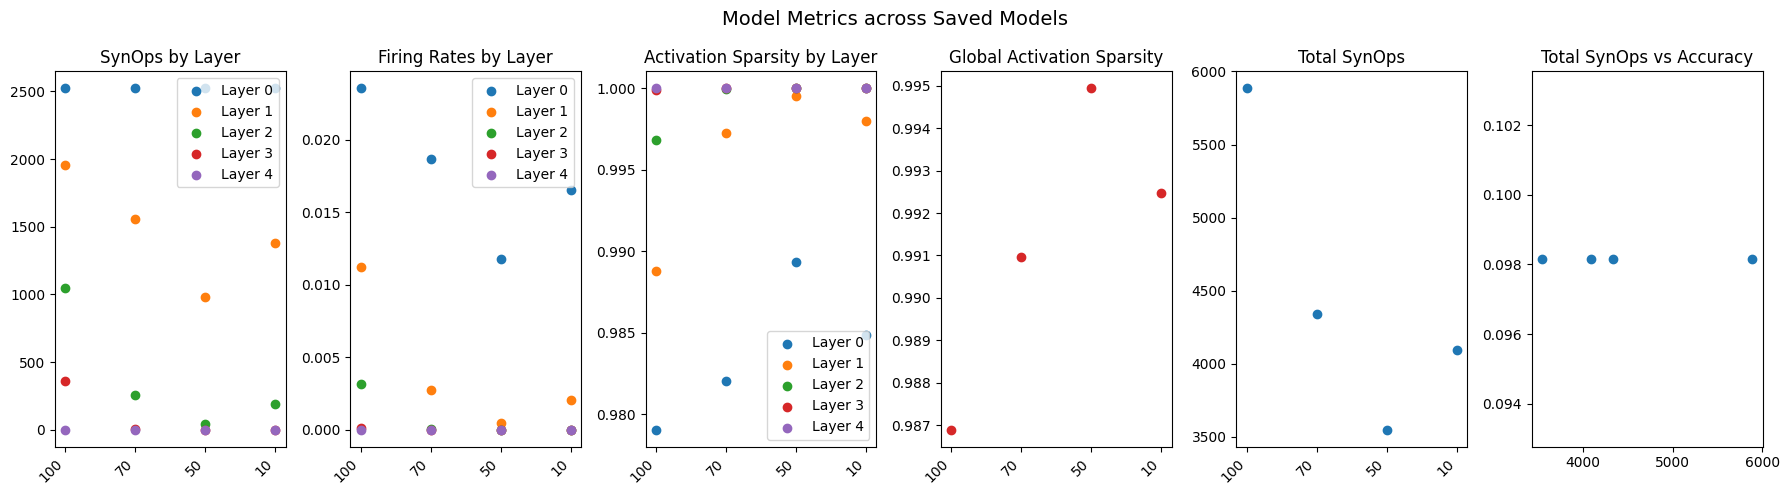

In [146]:

# Plot
fig, axs = plt.subplots(1, 6, figsize=(18, 5))
fig.suptitle("Model Metrics across Saved Models", fontsize=14)

x_positions = np.arange(len(df["model"]))  # numeric positions for scatter
x_labels = df["model"]

# Scatter SynOps by Layer
for i, layer in enumerate(np.stack(df['synops_per_layer'].to_numpy()).T):
    axs[0].scatter(x_positions, layer, label=f"Layer {i}")
axs[0].set_title("SynOps by Layer")
axs[0].set_xticks(x_positions)
axs[0].set_xticklabels(x_labels, rotation=45, ha='right')
axs[0].legend()

# Scatter Firing Rate by Layer
for i, layer in enumerate(np.stack(df['fire_rate_per_layer'].to_numpy()).T):
    axs[1].scatter(x_positions, layer, label=f"Layer {i}")
axs[1].set_title("Firing Rates by Layer")
axs[1].set_xticks(x_positions)
axs[1].set_xticklabels(x_labels, rotation=45, ha='right')
axs[1].legend()

# Scatter Activation Sparsity by Layer
for i, layer in enumerate(np.stack(df['act_sparsity_per_layer'].to_numpy()).T):
    axs[2].scatter(x_positions, layer, label=f"Layer {i}")
axs[2].set_title("Activation Sparsity by Layer")
axs[2].set_xticks(x_positions)
axs[2].set_xticklabels(x_labels, rotation=45, ha='right')
axs[2].legend()

# Scatter Global Activation Sparsity
axs[3].scatter(x_positions, df['total_act_sparsity'], color='tab:red')
axs[3].set_title("Global Activation Sparsity")
axs[3].set_xticks(x_positions)
axs[3].set_xticklabels(x_labels, rotation=45, ha='right')

# Scatter total SynOps
axs[4].scatter(x_positions, df['total_synops'], color='tab:blue')
axs[4].set_title("Total SynOps")
axs[4].set_xticks(x_positions)
axs[4].set_xticklabels(x_labels, rotation=45, ha='right')

# Scatter total SynOps
axs[5].scatter(df['total_synops'], df['accuracy'], color='tab:blue')
axs[5].set_title("Total SynOps vs Accuracy")

plt.tight_layout()
plt.show()

# Model deployment on Speck

In [ ]:
import time
import torch
import numpy as np
import pandas as pd
from collections import defaultdict

import samna
from sinabs.backend.dynapcnn import DynapcnnNetwork
from sinabs.backend.dynapcnn.chip_factory import ChipFactory
from sinabs.backend.dynapcnn.dynapcnn_visualizer import DynapcnnVisualizer
from tonic import datasets, transforms
import os
import pandas as pd


transform = transforms.Compose([
        transforms.ToFrame(sensor_size=(34, 34, 2), n_time_bins=30, include_incomplete=True),
        lambda x: torch.from_numpy(x.astype(np.float32)),
    ])

def run_hw(model_path, monitor_layers='all'):

    testset = datasets.NMNIST('./data', train=False, transform=transform)
    class_samples = {i: [] for i in range(10)}  # Dictionary to store samples for each class

    for data, label in testset:
        if len(class_samples[label]) < 10:
            class_samples[label].append(data)
        if all(len(samples) == 10 for samples in class_samples.values()):
            break

    data = torch.stack([torch.stack(samples) for samples in class_samples.values()]).numpy()
    data = data.reshape(-1, 30, 2, 34, 34)  # Reshape to [batch_size, time_bins, channels, height, width]


    devices = samna.device.get_unopened_devices()
    speck = samna.device.open_device(devices[0])
    device_id = 'speck2fdevkit'

    try:

        cnn = torch.load(model_path, weights_only=False, map_location='cpu')

        print("Initialized SpeckModel.")

        data_shape = [100] + [30,2,34,34]

        print(f"Data prepared with shape: {data_shape}")

        dynapcnn_model = DynapcnnNetwork(cnn[0:-1], input_shape=[2, 34, 34], dvs_input=False, discretize=True)
        print("Initialized DynapcnnNetwork.")
        dynapcnn_model.to(device_id, chip_layers_ordering="auto", monitor_layers='all', slow_clk_frequency=None)
        print("Model transferred to device.")
        layer_in = dynapcnn_model.chip_layers_ordering[0]


        chip_factory = ChipFactory(device_id)
        data = [chip_factory.raster_to_events(torch.from_numpy(x), layer=layer_in, dt=1/(data_shape[1]-1)) for x in data]
        print("Data converted to events.")

        pwr_mon = speck.get_power_monitor()
        source = pwr_mon.get_source_node()
        sink = samna.graph.sink_from(source)
        pwr_mon.start_auto_power_measurement(100.0)


        total_spike_num = 0
        total_neuro_num = 0
        layer_neuro_num = defaultdict(int)
        layer_spike_num = defaultdict(int)
        layer_sparsity = defaultdict(float)
        layer_outputs = defaultdict(list)

        start_ts = time.time()
        for sample in data:
            output_events = dynapcnn_model(sample)

            if monitor_layers is None:
                continue

            for id, layer in enumerate(dynapcnn_model.chip_layers_ordering):

                output_events_layer = [each for each in output_events if each.layer == layer]

                if len(output_events_layer) == 0:
                    layer_neuro_num[id] += 0
                    layer_spike_num[id] += 0
                    continue
                layer_outputs[id].append(output_events_layer)

        end_ts = time.time()
        print(f"Processed all data samples in {end_ts - start_ts} seconds.")

        pwr_mon.stop_auto_power_measurement()
        powers = pd.DataFrame([(x.channel, x.value) for x in sink.get_events()], columns=["ch", "pwr"])

    finally:

        samna.device.close_device(speck)
        print("Closed device.")

        powers = powers.groupby('ch').mean()['pwr'].to_list()
        fps = len(data) / (end_ts - start_ts)
        print(f"FPS: {fps}")

        dt= 1 / (data_shape[1] - 1)

        for layer in layer_outputs.keys():
            for i in range(len(layer_outputs[layer])):
                layer_n_spks = chip_factory.events_to_raster(layer_outputs[layer][i], dt=dt)

                tot_neurons = layer_n_spks.numel()
                tot_spikes = layer_n_spks.gt(0.0).sum().item()

                layer_neuro_num[layer] += tot_neurons
                layer_spike_num[layer] += tot_spikes

                total_spike_num += tot_spikes
                total_neuro_num += tot_neurons


        for key in layer_neuro_num:
                sparsity = (
                    (layer_neuro_num[key] - layer_spike_num[key])
                    / layer_neuro_num[key]
                    if layer_neuro_num[key] != 0
                    else 0.0
                )
                layer_sparsity[key] = sparsity

        activation_sparsity = ((total_neuro_num - total_spike_num) / total_neuro_num) if total_neuro_num != 0 else 0.0

        print(f"Total spikes: {total_spike_num}")
        print(f"Total neurons: {total_neuro_num}")
        print(f"Tot. Dynamic Power: {(powers[1]+ powers[2])*1e3} mW")

        print(f"Activation sparsity: {activation_sparsity}")

        return {
            'powers': powers,
            'fps': fps,
            'act_sparsity': activation_sparsity,
            'act_sp_by_layer': dict(layer_sparsity),
            'tot_spikes': total_spike_num
        }


Looking in indexes: https://gitlab.com/api/v4/projects/27423070/packages/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.1/122.1 MB 5.7 MB/s  0:00:210:00:0100:01
  Attempting uninstall: samna
    Found existing installation: samna 0.47.1
    Uninstalling samna-0.47.1:
      Successfully uninstalled samna-0.47.1


In [ ]:
model_files = [f for f in os.listdir("./saved_models/") if f.endswith('.pth')]
for model_file in model_files:
    model_path = os.path.join("./saved_models", model_file)

    print("Starting main execution.")
    print(f"Model name: {model_file}")
    power, fps, act_sparsity, act_sp_by_layer, tot_spikes = run_hw(model_path)
    print(f"Results completed for model {model_file}")

    all_results[model_file.removesuffix(".pth")].update(run_hw(model_path))

# Convert to DataFrame
df = pd.DataFrame(all_results)
df = df.T.reset_index().rename(columns={'index': 'model'})

display(df)

# Model statistics on Hardware

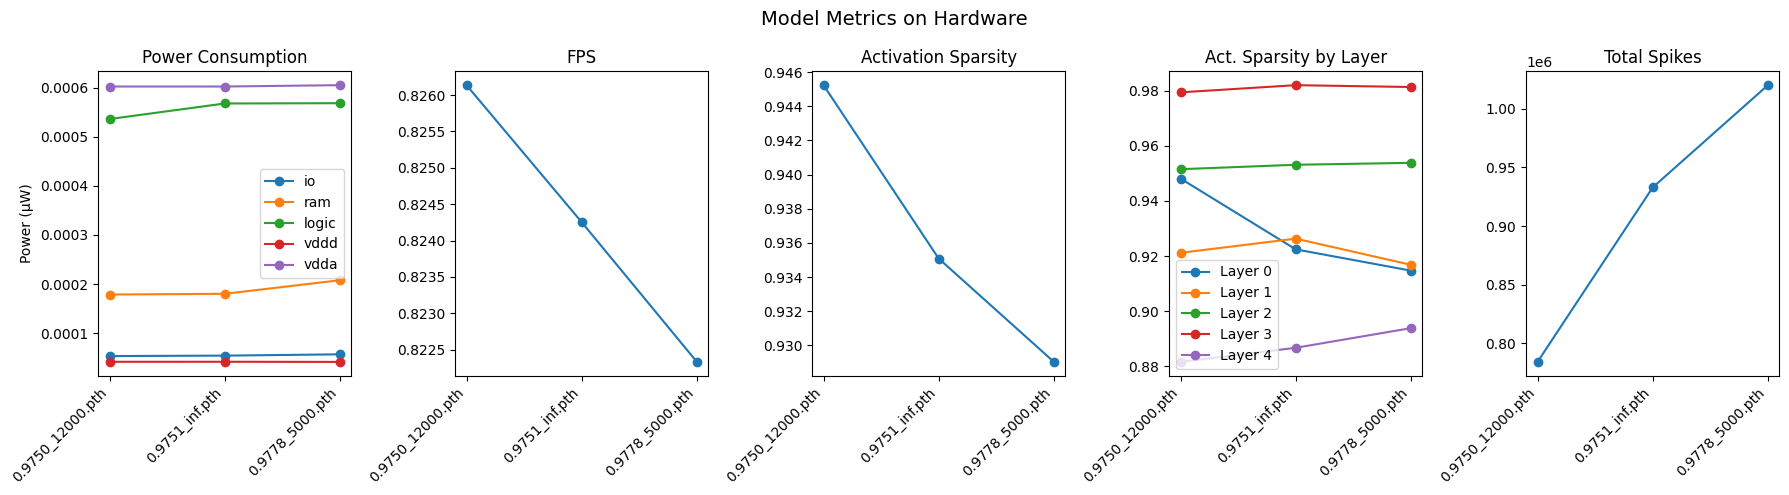

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pwr_chan_label = ["io", "ram", "logic", "vddd", "vdda"]

# Sort by model name (optional)
df.sort_values("model", inplace=True)

# Create x-axis positions
x_positions = np.arange(len(df["model"]))
x_labels = df["model"]

# Create subplots
fig, axs = plt.subplots(1, 5, figsize=(18, 5))
fig.suptitle("Model Metrics on Hardware", fontsize=14)


for i, ch in enumerate(np.stack(df['powers'].to_numpy()).T):
    axs[0].plot(x_positions, ch, '-o', label=f"{pwr_chan_label[i]}")
axs[0].set_title("Power Consumption")
axs[0].set_ylabel("Power (µW)")
axs[0].set_xticks(x_positions)
axs[0].set_xticklabels(x_labels, rotation=45, ha="right")
axs[0].legend()

axs[1].plot(x_positions, df['fps'], '-o')
axs[1].set_title("FPS")
axs[1].set_xticks(x_positions)
axs[1].set_xticklabels(x_labels, rotation=45, ha="right")

axs[2].plot(x_positions, df['act_sparsity'], '-o')
axs[2].set_title("Activation Sparsity")
axs[2].set_xticks(x_positions)
axs[2].set_xticklabels(x_labels, rotation=45, ha="right")

layer_sparsities = np.stack(df['act_sp_by_layer'].to_numpy()).T
sparsity_vectors = np.array([list(d.values()) for d in layer_sparsities])

for i in range(sparsity_vectors.shape[1]):
    axs[3].plot(x_positions, sparsity_vectors[:, i], '-o', label=f"Layer {i}")
axs[3].set_title("Act. Sparsity by Layer")
axs[3].set_xticks(x_positions)
axs[3].set_xticklabels(x_labels, rotation=45, ha="right")
axs[3].legend()

axs[4].plot(x_positions, df['tot_spikes'], '-o')
axs[4].set_title("Total Spikes")
axs[4].set_xticks(x_positions)
axs[4].set_xticklabels(x_labels, rotation=45, ha="right")

plt.tight_layout()
plt.show()

# NIR

Export model using Neuromorphic Intermediate Representation

In [148]:
from sinabs.nir import to_nir
import nir

model = create_model(batch_size=1)
model = model[1:-1]

os.makedirs('exported_models', exist_ok=True)

model_files = [f for f in os.listdir("./saved_models/") if f.endswith('.pth')]
for model_file in model_files:
    model_path = os.path.join("./saved_models", model_file)

    checkpoint = torch.load(model_path, weights_only=False, map_location='cpu')
    filtered_state_dict = {
        k: v for k, v in checkpoint.state_dict().items() if "v_mem" not in k
    }

    model.load_state_dict(filtered_state_dict, strict=False)

    nir_graph = to_nir(model, sample_data=torch.rand((1, 2, 34, 34)))
    nir_graph.infer_types()
    nir_model_name = model_file.replace('.pth', '.nir')
    nir.write(f"exported_models/{nir_model_name}", nir_graph)

[warning] 1.input_type undefined, set to input.output_type
[warning] 3.input_type undefined, set to 2.output_type
[warning] 5.input_type undefined, set to 4.output_type
[warning] 7.input_type undefined, set to 6.output_type
[warning] 9.input_type undefined, set to 8.output_type
[warning] 11.input_type undefined, set to 10.output_type
updateing flatten output
[warning] 1.input_type undefined, set to input.output_type
[warning] 3.input_type undefined, set to 2.output_type
[warning] 5.input_type undefined, set to 4.output_type
[warning] 7.input_type undefined, set to 6.output_type
[warning] 9.input_type undefined, set to 8.output_type
[warning] 11.input_type undefined, set to 10.output_type
updateing flatten output
[warning] 1.input_type undefined, set to input.output_type
[warning] 3.input_type undefined, set to 2.output_type
[warning] 5.input_type undefined, set to 4.output_type
[warning] 7.input_type undefined, set to 6.output_type
[warning] 9.input_type undefined, set to 8.output_type